## Do the Estimation with SCE and SPF data for UCSV model


### 1. Importing estimation codes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.tsa.api import AR
#from UCSVEst import UCSVEst as ucsv

In [2]:
from GMMEstSV import RationalExpectationSV as re
from GMMEstSV import StickyExpectationSV as se
from GMMEstSV import NoisyInformationSV as ni
from GMMEstSV import ParameterLearningSV as pl
from GMMEstSV import UCSV_simulator, ForecastPlotDiag, ForecastPlot

### 2. Preparing real-time data 

In [6]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [7]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [8]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [9]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [10]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [11]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [12]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

In [13]:
## Inflation data quarterly 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')

In [14]:
## process parameters estimation 
# period filter 
start_t='1995-01-01'
end_t = '2019-03-30'   

### quarterly data 
CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]
#Y = np.array(CPICQ[1:])
#X = np.array(CPICQ[:-1])

#ARmodel = AR(CPICQ)
#ar_rs = ARmodel.fit(1,trend='nc')
#rhoQ_est = ar_rs.params[0]
#sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))

In [15]:
### exporting the quarterly inflation series for process estimation using UCSV model in matlab

CPICQ.to_excel("../OtherData/CPICQ.xlsx")  ## this is for matlab estimation of UCSV model

CPICQ_UCSV_Est=pd.read_excel('../OtherData/estQ.xlsx',header=None)  
CPICQ_UCSV_Est.columns = ['sd_eta_est','sd_eps_est','tau']  ## Loading ucsv model estimates 

In [16]:
## Inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [17]:
### monthly data 
CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]
Y = np.array(CPIM[1:])
X = np.array(CPIM[:-1])

#ARmodel2 = AR(CPIM)
#ar_rs2 = ARmodel2.fit(1,trend='nc')
#rhoM_est = ar_rs2.params[0]
#sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [18]:
## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')

PopM = PopM[-PopM.date.isnull()]

dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')

dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')

In [19]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

In [20]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

historyQ = real_time_inf.copy()[real_time_inf.index.isin(indexQ)].loc[st_t_history:ed_t_SPF,:]
historyM = real_time_inf.copy().loc[st_t_history:ed_t_SCE,:]


#########################################################
## specific to stochastic vol model  
######################################################

n_burn_rt_history = len(CPICQ_UCSV_Est) - len(historyQ)  

history_vol_epsQ = np.array(CPICQ_UCSV_Est['sd_eps_est'][n_burn_rt_history:])**2
history_vol_etaQ = np.array(CPICQ_UCSV_Est['sd_eta_est'][n_burn_rt_history:])**2
history_volsQ = np.array([history_vol_epsQ,history_vol_etaQ])
history_etaQ = np.array(CPICQ_UCSV_Est['tau'][n_burn_rt_history:])

## to burn 
n_burn_Q = len(history_etaQ) - len(SPF_est['RTCPI'])
real_time_volsQ = history_volsQ[:,n_burn_Q:]
real_time_etaQ = history_etaQ[n_burn_Q:]

In [21]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
#SPF_est['Inf1yf_CPICore'].plot()
#plt.title('Realized 1-year-ahead Core CPI Inflation')

In [22]:
## preparing for estimation 

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


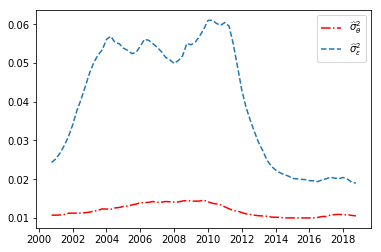

In [23]:
## Plot estimation of UCSV model 
date_history = np.array(list(CPICQ.index[n_burn_rt_history:]) )

## stochastic vols
plt.plot(date_history,history_vol_epsQ,'r-.',label=r'$\widehat\sigma^2_{\theta}$')
plt.plot(date_history,history_vol_etaQ,'--',label=r'$\widehat\sigma^2_{\epsilon}$')
plt.legend(loc=0)

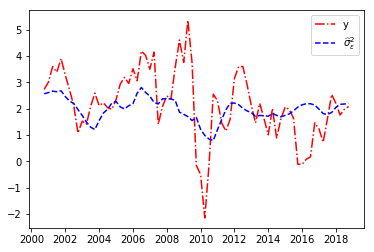

In [24]:
## inflation and the permanent component

plt.plot(date_history,np.array(historyQ['RTCPICore']),'r-.',label='y')
plt.plot(date_history,history_etaQ,'b--',label=r'$\widehat\sigma^2_{\epsilon}$')
plt.legend(loc=0)

### SE Estimation

#### SPF

moments used include ['Forecast']
moments used include ['FE']
moments used include ['Forecast', 'FE']
moments used include ['Forecast', 'FE', 'Disg']
moments used include ['Forecast', 'FE', 'Disg', 'Var']
[array([0.22900131]), array([0.11934128]), array([0.11941529]), array([0.1188049]), array([0.11856208])]
[]


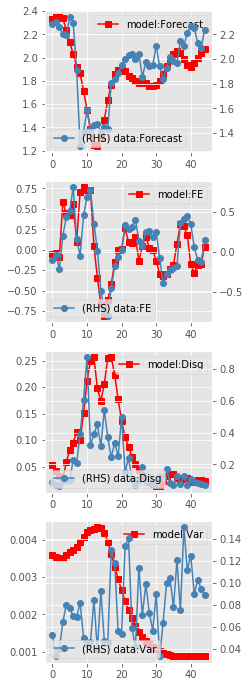

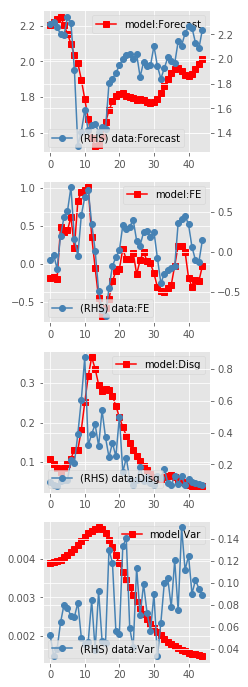

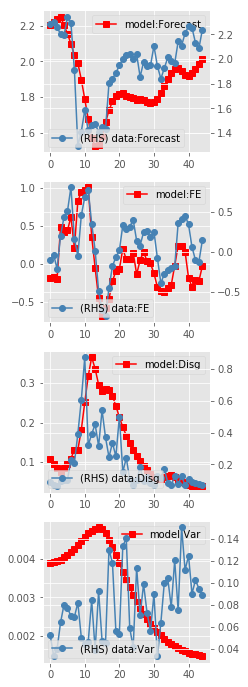

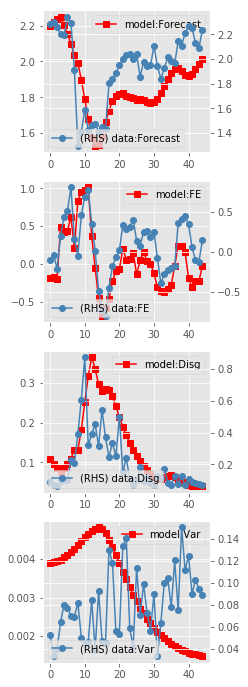

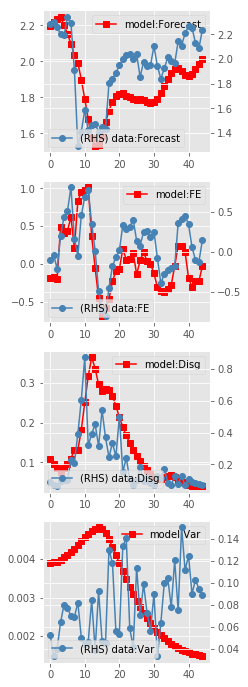

In [29]:
## SE loop estimation overdifferent choieces of moments for SPF

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg'],
                   ['Forecast','FE','Disg','Var']]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SPF_est['RTCPI'])
    history_Q = historyQ['RTCPICore']
    data_moms_dct = data_moms_dct_SPF
    ################################################################################
    process_paraQ_try = {'gamma':0.001,
                         'eta0': 0.1}   ## this does not matter basically 
    ################################################################################
    history_dct = {'eta':history_etaQ,
                   'vols':history_volsQ,
                   'y':history_Q}
    real_time_dct = {'eta':real_time_etaQ,
                   'vols':real_time_volsQ,
                   'y':real_time}
    SE_model = se(real_time = real_time_dct,
                  history = history_dct,
                  process_para = process_paraQ_try)
    SE_model.moments = moments_to_use
    SE_model.GetRealization(realized_CPIC)
    SE_model.GetDataMoments(data_moms_dct)
    
    # only expectation
    #####################################################################
    SE_model.ParaEstimate(method='L-BFGS-B',
                          para_guess = np.array([0.2]),
                          bounds = ((0,1),),
                          options={'disp':True})
    ####################################################################
    para_est_SPF_holder.append(SE_model.para_est)
    SE_model.all_moments = ['Forecast','FE','Disg','Var']
    SE_model.ForecastPlotDiag(all_moms = True,
                             diff_scale = True)
    #plt.savefig('figures/spf_se_est_diag'+str(i)+'.png')
    
    # joint estimate
    #SE_model.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.8,0.1),
    #                           bounds = ((0,1),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SPF_joint_holder.append(SE_model.para_est_joint)
    #SE_model.all_moments = ['Forecast','FE','Disg','Var']
    #SE_model.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/spf_se_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [31]:
## tabulate the estimates 
spf_se_est_para = pd.DataFrame(para_est_SPF_holder,columns=[r'SE: $\hat\lambda_{SPF}$(Q)'])
#spf_se_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
#                                     columns=[r'SE: $\hat\lambda_{SPF}$(Q)',
#                                              r'SE: $\rho$',
#                                              r'SE: $\sigma$'])

In [66]:
#spf_se_joint_est_para

NameError: name 'spf_se_joint_est_para' is not defined

In [32]:
spf_se_est_para

,SE: $\hat\lambda_{SPF}$(Q)
0,0.229001
1,0.119341
2,0.119415
3,0.118805
4,0.118562


#### SCE

moments used include ['Forecast']
moments used include ['FE']
moments used include ['Forecast', 'FE']
moments used include ['Forecast', 'FE', 'Disg']
moments used include ['Forecast', 'FE', 'Disg', 'Var']
[array([1.]), array([1.]), array([1.]), array([1.]), array([1.])]
[array([1. , 1. , 0.1]), array([0.15039179, 1.        , 0.1       ]), array([0.15150339, 1.        , 0.1       ]), array([0.14881095, 1.        , 0.1       ]), array([0.26486097, 1.        , 2.01545802])]


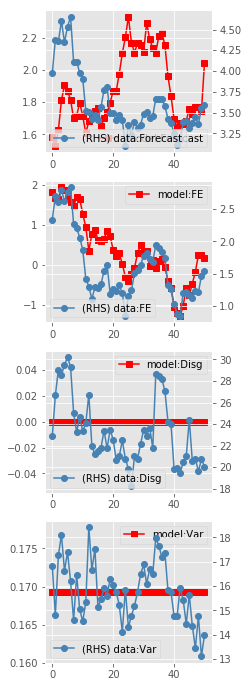

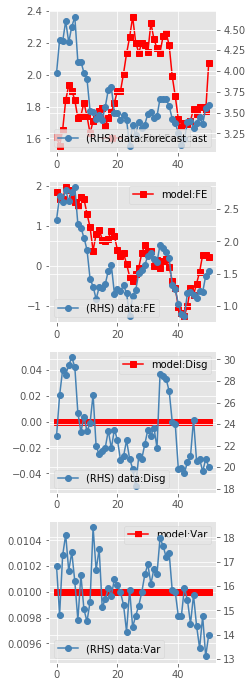

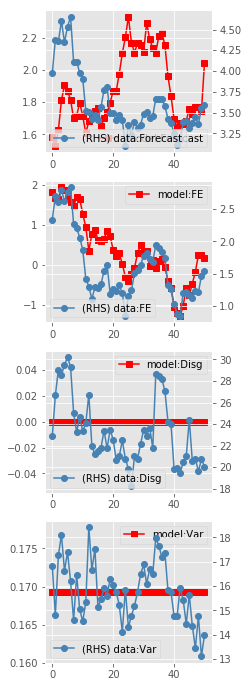

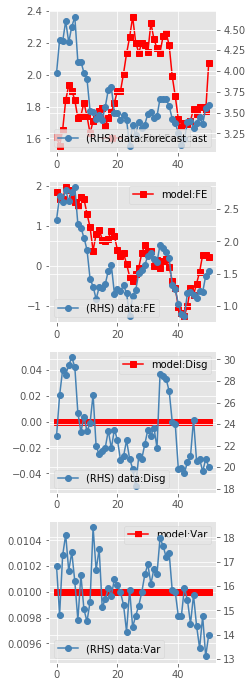

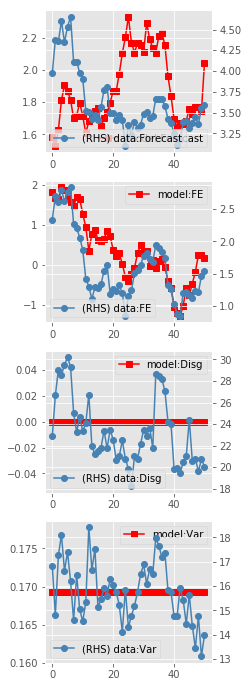

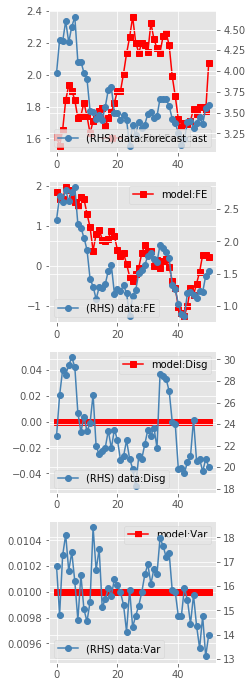

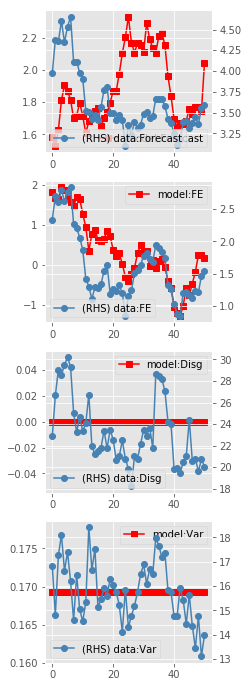

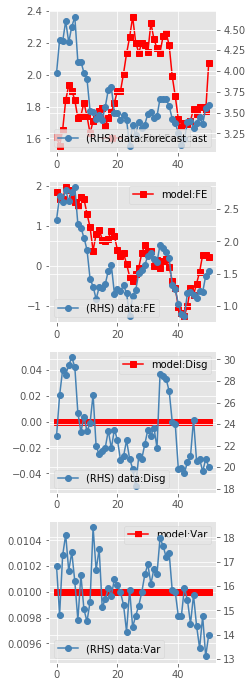

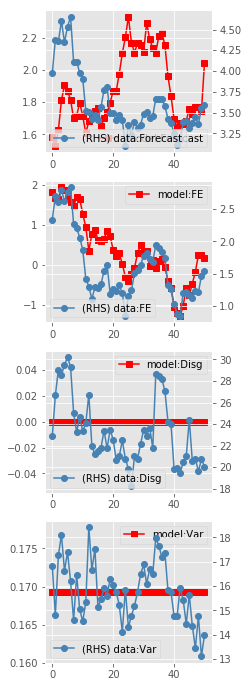

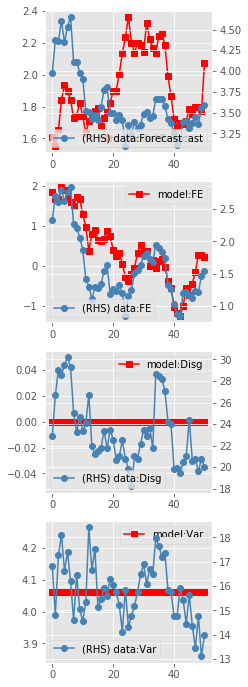

In [59]:
## SE loop estimation over different choieces of moments for SCE

moments_choices_short =[['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg'],
                   ['Forecast','FE','Disg','Var']]

para_est_SCE_holder = []
para_est_SCE_joint_holder =[]


for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    process_paraM_est = {'rho':rhoM_est,
                         'sigma':sigmaM_est}
    SE_model2 = se(real_time = realized_CPI,
                   history = history_M,
                   process_para = process_paraM_est)
    SE_model2.moments = moments_to_use
    SE_model2.GetRealization(realized_CPI)
    SE_model2.GetDataMoments(data_moms_dct)
    
    ## only expectation
    SE_model2.ParaEstimate(method='L-BFGS-B',
                           para_guess =(0.5),
                           bounds = ((0,1),),
                           options={'disp':True})
    para_est_SCE_holder.append(SE_model2.para_est)
    SE_model2.all_moments = ['Forecast','FE','Disg','Var']
    SE_model2.ForecastPlotDiag(all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_se_est_diag'+str(i)+'.png')
    
    ## joint estimation
    
    #SE_model2.ParaEstimateJoint(method='L-BFGS-B',
    #                            para_guess =(0.5,0.8,0.1),
    #                            bounds = ((0,1),(0,1),(0,None)),
    #                            options={'disp':True})
    #para_est_SCE_joint_holder.append(SE_model2.para_est_joint)
    #SE_model2.all_moments = ['Forecast','FE','Disg','Var']
    #SE_model2.ForecastPlotDiag(all_moms = True,
    #                          diff_scale = True)
    #plt.savefig('figures/sce_se_est_joint_diag'+str(i)+'.png')

print(para_est_SCE_holder)
print(para_est_SCE_joint_holder)

In [60]:
sce_se_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'SE: $\hat\lambda_{SCE}$(M)'])
sce_se_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
                                     columns = [r'SE: $\hat\lambda_{SCE}$(M)',
                                                r'SE: $\rho$',
                                                r'SE: $\sigma$'])

In [61]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
se_est_df = pd.concat([est_moms,
                       spf_se_est_para,
                       spf_se_joint_est_para,
                       sce_se_est_para,
                       sce_se_joint_est_para], 
                      join='inner', axis=1)

In [62]:
sce_se_est_para

,SE: $\hat\lambda_{SCE}$(M)
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [63]:
sce_se_joint_est_para

,SE: $\hat\lambda_{SCE}$(M),SE: $\rho$,SE: $\sigma$
0,1.000000,1.0,0.100000
1,0.150392,1.0,0.100000
2,0.151503,1.0,0.100000
3,0.148811,1.0,0.100000
4,0.264861,1.0,2.015458


In [64]:
se_est_df.to_excel('tables/SE_Est.xlsx',
                   float_format='%.2f',
                   index=False)

### NI Estimation 
#### SPF

moments used include ['Forecast']
moments used include ['FE']
moments used include ['Forecast', 'FE']
moments used include ['Forecast', 'FE', 'Disg']
moments used include ['Forecast', 'FE', 'Disg', 'Var']
[array([0.51362699, 0.01708123, 0.52074857, 1.        , 5.        ]), array([0.        , 0.58731671, 1.10461178, 1.        , 5.        ]), array([6.45459482e-04, 5.22422670e-01, 1.09243189e+00, 1.00000000e+00,
       5.00000000e+00]), array([0.        , 0.14124613, 1.05783188, 1.        , 5.        ]), array([0.        , 0.10772475, 1.05934377, 1.        , 5.        ])]
[]


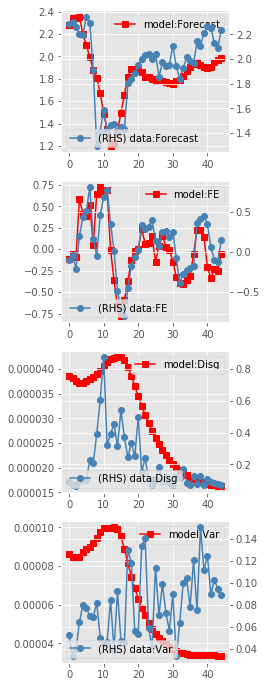

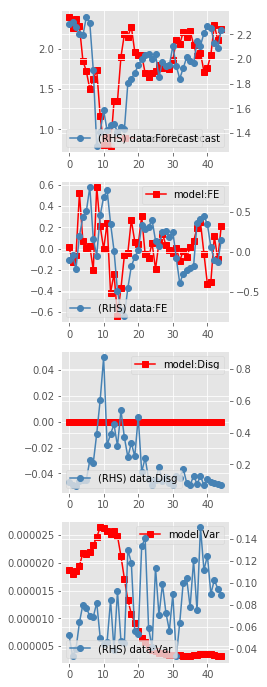

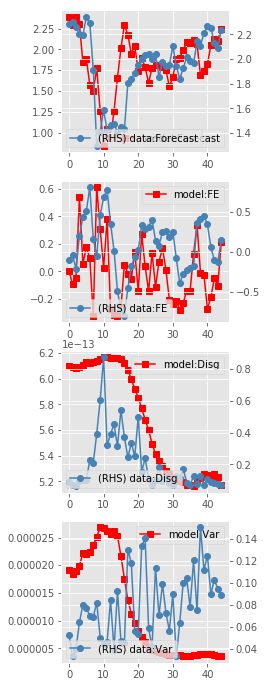

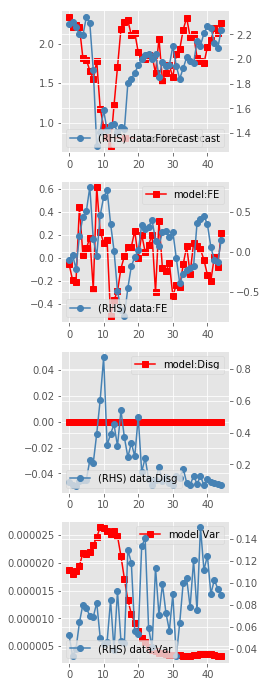

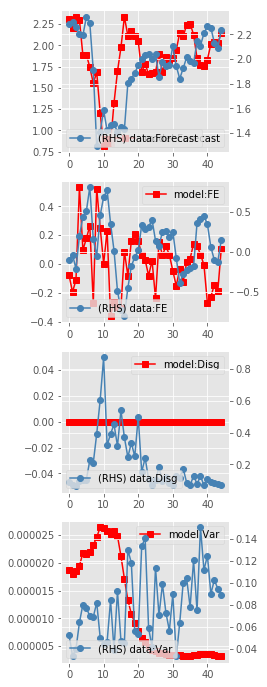

In [37]:
## NI loop estimation overdifferent choieces of moments for SPF

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg'],
                   ['Forecast','FE','Disg','Var']]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SPF_est['RTCPI'])
    history_Q = historyQ['RTCPICore']
    data_moms_dct = data_moms_dct_SPF
    ################################################################################
    process_paraQ_try = {'gamma':10,
                         'eta0': 0.1}   ## this does not matter basically 
    ################################################################################
    history_dct = {'eta':history_etaQ,
                   'vols':history_volsQ,
                   'y':history_Q}
    real_time_dct = {'eta':real_time_etaQ,
                   'vols':real_time_volsQ,
                   'y':real_time}
    NI_model = ni(real_time = real_time_dct,
                  history = history_dct,
                  process_para = process_paraQ_try)
    NI_model.SimulateSignals()
    NI_model.moments = moments_to_use
    NI_model.GetRealization(realized_CPIC)
    NI_model.GetDataMoments(data_moms_dct)
    
    # only expectation
    NI_model.ParaEstimate(method='L-BFGS-B',
                          para_guess =(0.5,0.5,0.1,1,5),
                          bounds = ((0,None),(0,None),(0,None),(None,None),(0,None)),
                          options={'disp':True})
    para_est_SPF_holder.append(NI_model.para_est)
    NI_model.all_moments = ['Forecast','FE','Disg','Var']
    NI_model.ForecastPlotDiag(all_moms = True,
                             diff_scale = True)
    #plt.savefig('figures/spf_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.5,0.1,1,5,0.8,0.1),
    #                           bounds = ((0,None),
    #                                     (0,None),
    #                                     (0,None),
    #                                     (None,None),
    #                                     (0,None),
    #                                     (0,1),
    #                                     (0,None)),
    #                           options={'disp':True})
    #para_est_SPF_joint_holder.append(NI_model.para_est_joint)
    #NI_model.all_moments = ['Forecast','FE','Disg','Var']
    #NI_model.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/spf_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [38]:
## tabulate the estimates 
spf_ni_est_para = pd.DataFrame(para_est_SPF_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SPF}$',
                                        r'$\hat\sigma_{pr,SPF}$',
                                        r'$Var$',
                                        r'$y$',
                                        'Disg'])
#spf_ni_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SPF}$',
#                                              r'$\hat\sigma_{pr,SPF}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])

In [39]:
spf_ni_est_para

,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$",$Var$,$y$,Disg
0,0.513627,0.017081,0.520749,1.0,5.0
1,0.000000,0.587317,1.104612,1.0,5.0
2,0.000645,0.522423,1.092432,1.0,5.0
3,0.000000,0.141246,1.057832,1.0,5.0
4,0.000000,0.107725,1.059344,1.0,5.0


#### SCE

moments used include ['Forecast']
moments used include ['FE']
moments used include ['Forecast', 'FE']
moments used include ['Forecast', 'FE', 'Disg']
moments used include ['Forecast', 'FE', 'Disg', 'Var']
[array([   4.16849061, 1163.19756369,   94.09572825,  430.69071897,
          5.        ]), array([88.25663931,  0.21048286,  0.1       ,  1.        ,  5.        ]), array([0.25793497, 0.95183937, 0.1       , 1.        , 5.        ]), array([0.        , 1.29117386, 0.1       , 1.        , 5.        ]), array([1.3675089, 0.       , 0.1      , 1.       , 5.       ])]


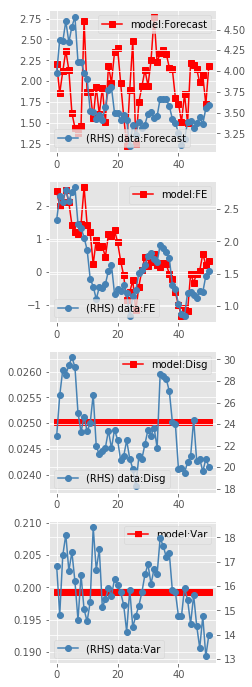

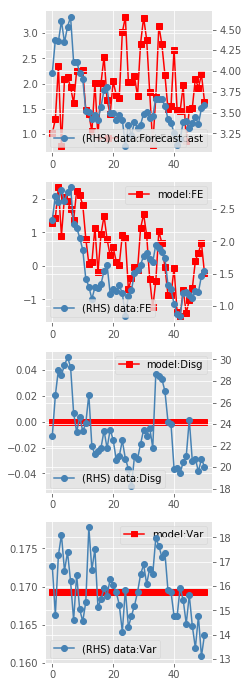

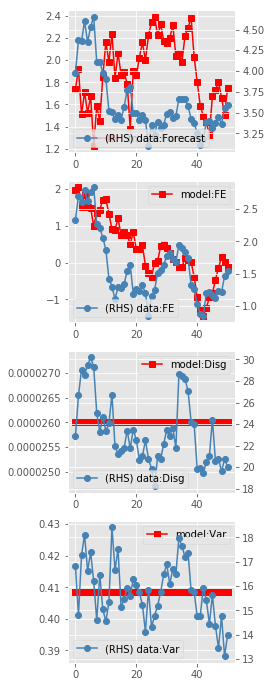

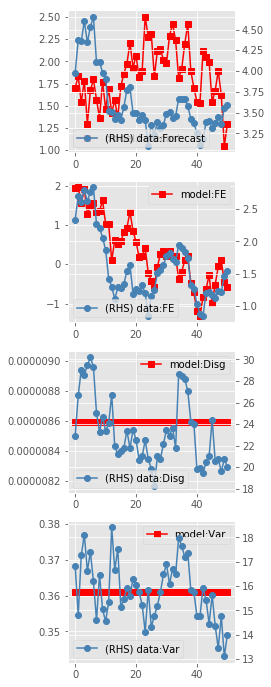

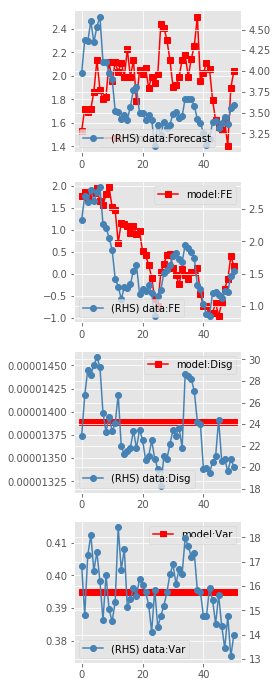

In [52]:
## NI loop estimation overdifferent choieces of moments for SCE

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg'],
                   ['Forecast','FE','Disg','Var']]

para_est_SCE_holder = []
para_est_SCE_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    process_paraM_est = {'rho':rhoM_est,
                         'sigma':sigmaM_est}
    NI_model2 = ni(real_time = real_time,
                   history = history_M,
                   process_para = process_paraM_est)
    NI_model2.SimulateSignals()
    NI_model2.moments = moments_to_use
    NI_model2.GetRealization(realized_CPI)
    NI_model2.GetDataMoments(data_moms_dct)
    
    # only expectation
    NI_model2.ParaEstimate(method='L-BFGS-B',
                           para_guess =(0.5,0.5,0.5,1,10),
                           bounds =((0,None),(0,None),(0,None),(None,None),(0,None)),
                           options={'disp':True})
    para_est_SCE_holder.append(NI_model2.para_est)
    NI_model2.all_moments = ['Forecast','FE','Disg','Var']
    NI_model2.ForecastPlotDiag(all_moms = True,
                              diff_scale = True)
    plt.savefig('figures/sce_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model2.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.5,0.1,0.8,0.1),
    #                           bounds = ((0,None),(0,None),(0,None),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SCE_joint_holder.append(NI_model2.para_est_joint)
    #NI_model.all_moments = ['Forecast','FE','Disg','Var']
    #NI_model2.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/sce_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [53]:
## tabulate the estimates 
sce_ni_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SCE}$',
                                        r'$\hat\sigma_{pr,SCE}$',
                                        r'$Var$',
                                        r'$y$',
                                        'Disg'])
#sce_ni_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SCE}$',
#                                              r'$\hat\sigma_{pr,SCE}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])


In [54]:
sce_ni_est_para

,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",$Var$,$y$,Disg
0,1.009691,0.194847,0.5,1.0,10.0
1,1.329332,0.000000,0.5,1.0,10.0
2,0.788629,59.223497,0.5,1.0,10.0
3,0.660664,78.838923,0.5,1.0,10.0
4,0.752054,75.445577,0.5,1.0,10.0


In [70]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
ni_est_df = pd.concat([est_moms,
                       spf_ni_est_para,
                       spf_ni_joint_est_para,
                       sce_ni_est_para,
                       sce_ni_joint_est_para],
                      join='inner', axis=1)

In [71]:
ni_est_df.to_excel('tables/NI_Est.xlsx',
                   float_format='%.2f',
                   index=False)

In [42]:
## NI estimation for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

NI_model2 = ni(real_time = real_time,
               history = history_M,
               process_para = process_paraM_est)
NI_model2.SimulateSignals()
NI_model2.GetRealization(realized_CPI)
NI_model2.GetDataMoments(data_moms_dct)
NI_model2.moments = ['Forecast','FE','Disg','Var']
NI_model2.ParaEstimate(method = 'L-BFGS-B',
                       bounds = ((0,None),(0,None),(0,None),(0,None),(0,None)),
                       options={'disp':True})

sigmas_est_SCE = NI_model2.para_est

In [43]:
sigmas_est_SCE

array([  0.86728868, 101.91660426,   0.2       ,   2.        ,
        10.        ])

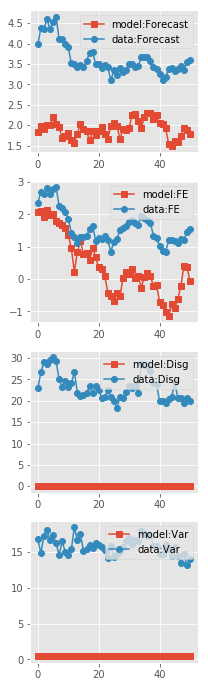

In [44]:
## compare the data with estimation for SCE

NI_model2.ForecastPlotDiag()

In [66]:
print(str(sigmas_est_SPF))
print(str(sigmas_est_SCE))

[0.80760731 2.16168125 0.01000169]
[ 5329.26176221   332.66740906 14215.10002247]


In [45]:
### Estimate of Parameter Learning for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

PL_model = pl(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model.GetRealization(realized_CPIC)
PL_model.LearnParameters()
moms_pl_sim = PL_model.Forecaster()
PL_model.GetDataMoments(data_moms_dct)

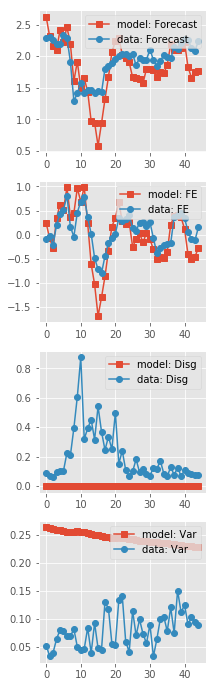

In [46]:
pl_plot = ForecastPlotDiag(moms_pl_sim,
                           data_moms_dct,
                           legends=['model','data'])

In [47]:
### Estimate of Parameter Learning for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct2 = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

PL_model2 = pl(real_time = real_time,
              history = history_M,
              process_para = process_paraM_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model2.GetRealization(realized_CPI)
PL_model2.LearnParameters()
moms_pl_sim2 = PL_model2.Forecaster()
PL_model2.GetDataMoments(data_moms_dct2)

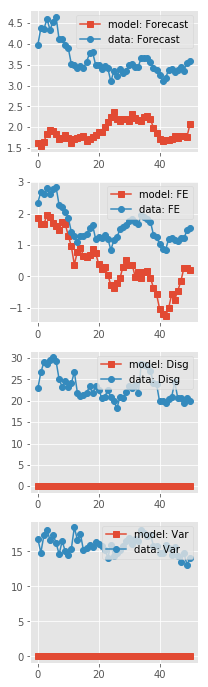

In [48]:
pl_plot = ForecastPlotDiag(moms_pl_sim2,
                           data_moms_dct2,
                           legends=['model','data'])

In [2]:
'''
NI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],
                'sigma_pr':sigmas_est_SPF[0][1],
                'var_init':sigmas_est_SPF[0][2]}

NI_model.exp_para = NI_model_sim_est
NI_model.SimulateSignals()
ni_sim_moms_dct = NI_model.Forecaster()
'''

"\nNI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],\n                'sigma_pr':sigmas_est_SPF[0][1],\n                'var_init':sigmas_est_SPF[0][2]}\n\nNI_model.exp_para = NI_model_sim_est\nNI_model.SimulateSignals()\nni_sim_moms_dct = NI_model.Forecaster()\n"

In [3]:
#NI_model.exp_para

In [4]:
'''
plt.figure(figsize=([3,13]))
for i,key in enumerate(ni_sim_moms_dct):
    plt.subplot(4,1,i+1)
    print(key)
    plt.plot(ni_sim_moms_dct[key],label='Model')
    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')
    plt.legend(loc=1)
'''

"\nplt.figure(figsize=([3,13]))\nfor i,key in enumerate(ni_sim_moms_dct):\n    plt.subplot(4,1,i+1)\n    print(key)\n    plt.plot(ni_sim_moms_dct[key],label='Model')\n    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')\n    plt.legend(loc=1)\n"